In [1]:
import sys
sys.path.append('../../')
import cresthh
from cresthh import anuga
from osgeo import gdal
from glob import glob
from affine import Affine
import geopandas as gpd
from pyproj import Proj, CRS, transform
import os

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
study_area= gpd.read_file('/home/ZhiLi/CRESTHH/data/HoustonCase/study_area/Houston_basin.shp')
inner_zone_channel= gpd.read_file('/home/ZhiLi/CRESTHH/data/HoustonCase/river_buffer/Houston_river_buffer.shp')
# inner_zone_plain= gpd.read_file('/home/ZhiLi/CRESTHH/data/HoustonCase/flood_plain/Houston_plain_buffer.shp')
# houses= gpd.read_file('/home/ZhiLi/CRESTHH/data/HoustonCase/houses/houses.shp')
topography_file = '/hydros/ZhiLi/DEM_10m_filled.tif'
base_resolution = 1000000 #1km
channel_resolution= 10000 #10 m
floodPlainResolution= 10000 #100m
proj= "+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
wgs84= CRS('EPSG:4326')
UTM= CRS(proj)


In [3]:
lons= np.array(study_area.exterior[0].coords)[:,0]; lats=np.array(study_area.exterior[0].coords)[:,1]
myProj = Proj("+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
utm_coords_domain= [myProj(lon,lat) for (lon, lat) in zip(lons, lats)]
# lons= np.array(inner_zone_channel.geometry[0])[:,0]; lats=np.array(inner_zone_channel.geometry[0])[:,1]
coords_inner_channel= np.concatenate([np.array(inner_zone_channel.boundary[0][i].coords) for i in range(len(inner_zone_channel.boundary[0]))])
utm_coords_channel= [myProj(lon,lat) for (lon, lat) in coords_inner_channel]
coords_inner_plain= np.concatenate([np.array(inner_zone_plain.boundary[0][i].coords) for i in range(len(inner_zone_plain.boundary[0]))])
# lons= np.array(inner_zone_plain.geometry[0])[:,0]; lats=np.array(inner_zone_plain.geometry[0])[:,1]
utm_coords_plain= [myProj(lon,lat) for (lon, lat) in coords_inner_plain]

# coords_houses= np.concatenate([np.array(houses.boundary[i].coords) for i in range(len(houses))])
# utm_coords_houses= [myProj(lon,lat) for (lon, lat) in coords_houses]

In [4]:
utm_coords_houses= []
try:
    for i in range(len(houses)):
        coords_houses= np.array(houses.boundary[i].coords)
        utm_coords_houses.append([myProj(lon,lat) for (lon, lat) in coords_houses])
except:
    pass

[]
Figure files for each frame will be stored in _plot


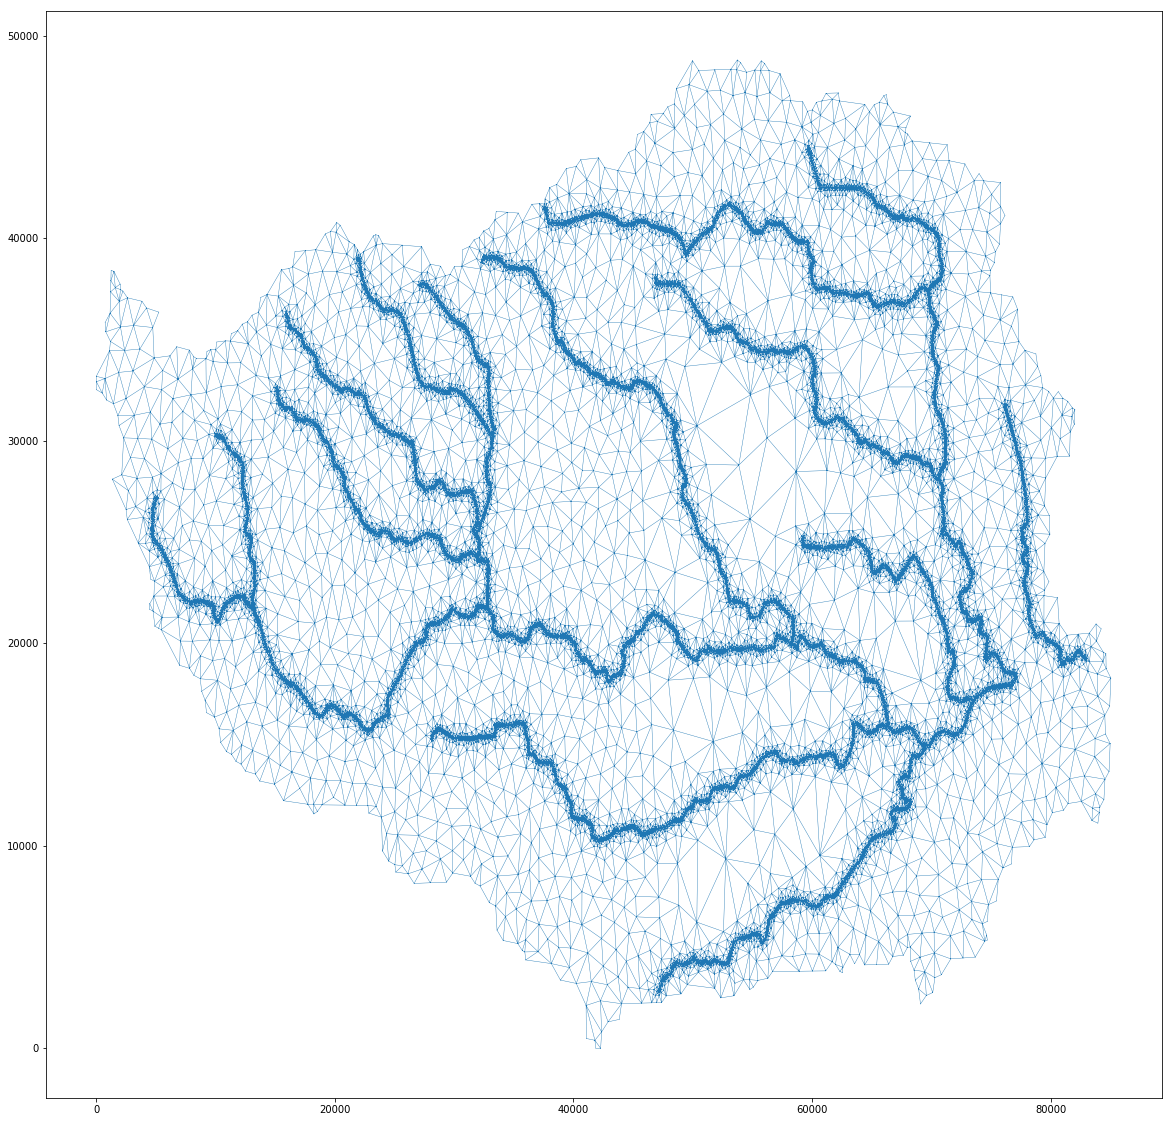

In [4]:
if os.path.exists('test.msh'):
    domain= anuga.create_domain_from_file('test.msh')
else:
    domain = anuga.create_domain_from_regions(
                utm_coords_domain,
                boundary_tags={'bottom': [0]},
                maximum_triangle_area=1000000,
                interior_regions=[[utm_coords_channel, channel_resolution]],
    #                               [utm_coords_plain, floodPlainResolution]],
    #             interior_holes=utm_coords_houses,
                minimum_triangle_angle= 20,
                mesh_filename='test.msh'
                )

domain.set_name('test') # Name of sww file
dplotter = anuga.Domain_plotter(domain)  
fig= plt.figure(figsize=(20,20))
plt.triplot(dplotter.triang, linewidth = 0.4);

In [6]:
print 'Number of elements:',domain.number_of_elements

Number of elements: 142893


In [8]:
domain.areas.min()

2.1457672119140625e-05

In [5]:
domain.areas.min()

0.0001519918441772461

In [10]:
domain.areas.max()

7419303.781901121

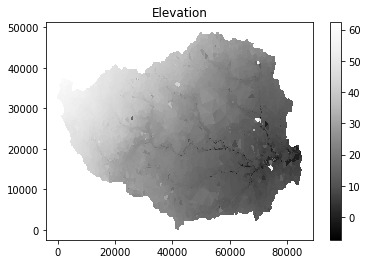

In [5]:
start= '20170825000000'
end= '20170829000000'
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', filename='/home/ZhiLi/CRESTHH/data/Texas_friction/manningn.tif', location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 
domain.set_quantity('SM', 0.01, location='centroids')
domain.set_quantity('Ksat', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/ksat.tif', location='centroids')
domain.set_quantity('WM', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/wm_10m.tif', location='centroids')
domain.set_quantity('B', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/b_10m.tif', location='centroids')
domain.set_quantity('IM', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/im.tif', location='centroids')
domain.set_quantity('KE', 0.89, location='centroids')
domain.set_coupled(True)

domain.set_evap_dir('/home/ZhiLi/CRESTHH/data/evap', pattern='cov_et17%m%d.asc.tif', freq='1D')
# domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/precip',pattern='nimerg%Y%m%dS%H%M%S.tif', freq='1H')
domain.set_precip_dir('/hydros/MengyuChen/mrmsPrecRate',pattern='PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif', freq='2M')
domain.set_timestamp(start, format='%Y%m%d%H%M%S')
domain.set_time_interval('2M')
total_seconds= (pd.to_datetime(end) - pd.to_datetime(start)).total_seconds()

plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar();
plt.title("Elevation");

# splotter= anuga.SWW_plotter('68500.sww')
xc = splotter.xc + splotter.xllcorner
yc = splotter.yc + splotter.yllcorner
        

# initialize water depth
origin= (-95.43666, 30.11085)
origin_utm= myProj(origin[0],origin[1])
iloc= np.argmin( (xc-origin_utm[0])**2 + (yc-origin_utm[1])**2 )
# second= (-95.646063,30.11935)
# second_utm= myProj(second[0],second[1])
# dist= ((origin_utm[0]-second_utm[0])**2+ (origin_utm[1]-second_utm[1])**2)

origin_val= 4.3
second_val=3.6

all_values= []
all_ilocs= []
for cor in utm_coords_int:
    _dist= ((origin_utm[0]-cor[0])**2+ (origin_utm[1]-cor[1])**2)
    _val= origin_val - (origin_val-second_val)/dist * _dist
    _iloc= np.argmin( (xc-cor[0])**2 + (yc-cor[1])**2 )
    all_values.append(_val)
    all_ilocs.append(_iloc)

domain.quantities['stage'].centroid_values[all_ilocs]+= all_values

In [7]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)
Bi = anuga.Dirichlet_boundary([0, 0, 0]) 

domain.set_boundary({'bottom':   Bt,
                     'interior': Br,
                     'exterior': Bi})

In [7]:
domain.flow_algorithm

'DE0'

In [18]:
domain.radius

AttributeError: Domain instance has no attribute 'radius'

In [22]:
domain.areas.min()

3.0279159545898438e-05

domain.set_coupled(False)
# Rain = anuga.Quantity(domain, name='Rain')
# ET= anuga.Quantity(domain, name='ET')
# forcing_op= anuga.Rate_operator(domain, rate=Rain+ET)
# rain_op = anuga.Rate_operator(domain, rate = Rain)
# et_op = anuga.Rate_operator(domain, rate= Evap)
# Rain= anuga.Rate_operator(domain, rate=lambda t: 5 if t<5 else 10)
for i,t in enumerate(domain.evolve(yieldstep=120, duration=total_seconds)):
#     current_rain_file = sorted(glob(external_dir+'/*.tif'))[i]
#     print(current_rain_file)
#     Rain.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     ET.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0, vmax=30)
#     domain.print_operator_timestepping_statistics()
    domain.print_timestepping_statistics()
#     domain.report_water_volume_statistics()

    stage = domain.get_quantity('stage')
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    print 'integral = ', height.get_integral()    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation()

# Results interpretation

In [124]:
splotter = anuga.SWW_plotter('Aug_Sep_coupled.sww')

Figure files for each frame will be stored in _plot


In [126]:
dr= pd.date_range('20170801', '20170901', freq='120S')

In [172]:
period= pd.date_range('20170825', '20170831', freq='120S')

In [173]:
ibegin= dr.get_loc(period[0], method='nearest')
iend= dr.get_loc(period[-1], method='nearest')

In [174]:
OBS= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/08068500.txt', delimiter='\t',
                 names=['USGS','ID','date','TZ','Q',' ','H',' '], converters={'date':pd.to_datetime}).set_index('date')
OBS.index= OBS.index.tz_localize('US/Central').tz_convert('UTC').tz_localize(None)
obs= OBS.resample('120S', label='right').mean().interpolate()
stage= splotter.stage[:,iloc]

In [184]:
splotter.stage.shape

(22321, 2826)

In [192]:
df= pd.DataFrame(index= period)
df['sim']= splotter.stage[ibegin:iend+1,iloc]
df['obs']= obs.loc[period].H*0.306


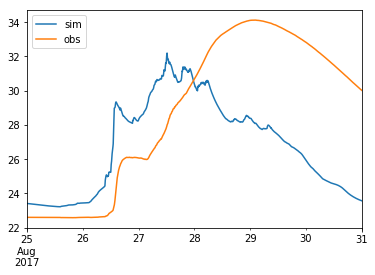

In [193]:
df.plot()

In [142]:
df.corr()

,obs,sim
obs,1.000000,0.712908
sim,0.712908,1.000000


In [133]:
second= (-95.646063,30.11935)
second_utm= myProj(second[0],second[1])

iloc_second= np.argmin( (xc-second_utm[0])**2 + (yc-second_utm[1])**2 )

In [134]:
OBS= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/08068275.txt', delimiter='\t',
                 names=['USGS','ID','date','TZ','Q',' ','H',' '], converters={'date':pd.to_datetime}).set_index('date')
OBS.index= OBS.index.tz_localize('US/Central').tz_convert('UTC').tz_localize(None)
obs= OBS.resample('120S', label='right').mean().interpolate()

In [135]:
df= pd.DataFrame(index= dr)
df['obs']= obs.loc[dr].H*0.3048
df['sim']= splotter.stage[:,iloc_second]

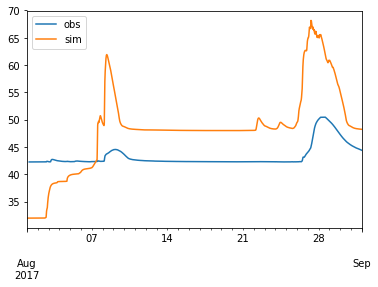

In [136]:
df.plot()

In [138]:
df.corr()

,obs,sim
obs,1.000000,0.655501
sim,0.655501,1.000000


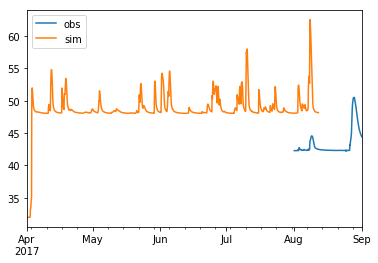

In [18]:
df= pd.DataFrame(index= dr)
df['obs']= obs.loc[dr].H*0.3048
df['sim']= splotter.stage[:,iloc_second]

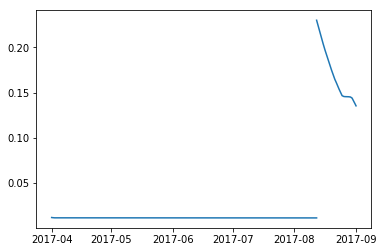

In [33]:
plt.plot(dr,splotter.SM[:,iloc])

for i,time in enumerate(splotter.time):
    splotter.save_depth_frame(frame=i)
    print(time)
splotter.make_depth_animation()